In [1]:
import math
import os
import collections
import multiprocessing
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchtext
import datasets
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
splits = {
    'train': 0.1,
    'val': 0.05,
    'test': 0.05
}

vocab_len = 20_000

batch_size = 64
seq_len = 128
emb_dim = 256

data_step = seq_len / 2

n_blocks = 4
n_heads = 4
d_ff = 512
dropout = 0.1

lr = 3e-4
epochs = 20
patience = 5
lr_factor = 0.1
lr_patience = 2
min_lr = 1e-5

In [3]:
multiprocessing.set_start_method('fork')

In [4]:
dataset = datasets.load_dataset('wikipedia', '20220301.simple', trust_remote_code=True)
dataset

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 205328
    })
})

In [5]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [6]:
def _tokenize(sample):
    sample['tokens'] = tokenizer(sample['text'])
    return sample


dataset = dataset.map(_tokenize, remove_columns=['text'], num_proc=os.cpu_count())
dataset

Map (num_proc=4):   0%|          | 0/205328 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'tokens'],
        num_rows: 205328
    })
})

In [7]:
train_set = dataset['train']
train_set, test_set = train_set.train_test_split(int(splits['test'] * len(train_set)), seed=0).values()
train_set, val_set = train_set.train_test_split(int(splits['val'] * len(train_set)), seed=0).values()
_, train_set = train_set.train_test_split(int(splits['train'] * len(train_set)), seed=0).values()
data_splits = {
    'train': train_set,
    'val': val_set,
    'test': test_set
}
len(train_set), len(val_set), len(test_set)

(18530, 9753, 10266)

In [8]:
def build_sample_map(dataset, seq_len):
    map = []
    for idx, sample in enumerate(tqdm(dataset)):
        tokens = sample['tokens']
        n_samples = len(tokens) - (seq_len + 1)
        if n_samples < 1:
            continue
        map.extend([(idx, i) for i in range(n_samples)])
    return map


sample_maps = {}
for split in splits:
    filename = f'sample_map-{split}-{seq_len}.pt'
    try:
        sample_map = torch.load(filename)
    except FileNotFoundError:
        sample_map = build_sample_map(data_splits[split], seq_len=seq_len)
        sample_map = torch.tensor(sample_map)
        torch.save(sample_map, filename)
    sample_maps[split] = sample_map
[len(sample_maps[split]) for split in splits]

  0%|          | 0/18530 [00:00<?, ?it/s]

  0%|          | 0/9753 [00:00<?, ?it/s]

  0%|          | 0/10266 [00:00<?, ?it/s]

[2099498, 1181380, 1106005]

In [9]:
filename = f'vocab-{vocab_len}.pt'
try:
    vocab = torch.load(filename)
except FileNotFoundError:
    vocab = torchtext.vocab.build_vocab_from_iterator((sample['tokens'] for sample in tqdm(data_splits['train'])), specials=['<pad>', '<unk>'], max_tokens=vocab_len)
    vocab.set_default_index(vocab['<unk>'])
    torch.save(vocab, filename)
len(vocab)

  0%|          | 0/18530 [00:00<?, ?it/s]

20000

In [10]:
class SequenceDataset(data.Dataset):
    def __init__(self, dataset, seq_len, tokenizer, vocab, sample_map, cache=False):
        super().__init__()
        self.dataset = dataset
        self.seq_len = seq_len
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.sample_map = sample_map
        self.len = len(sample_map)
        self.cache = None
        if cache:
            self.cache = dataset['tokens']

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        idx = int(idx)  # sample dataset passes tensor indices
        ds_idx, start_idx = self.sample_map[idx]
        ds_idx, start_idx = int(ds_idx), int(start_idx)  # sample map is a tensor
        tokens = self.dataset[ds_idx]['tokens'] if self.cache is None else self.cache[ds_idx]
        tokens = tokens[start_idx:start_idx + self.seq_len + 1]
        indices = self.vocab.lookup_indices(tokens)
        indices = torch.tensor(indices)
        x, y = indices[:-1], indices[1:]
        return x, y


seq_data = {split: SequenceDataset(data_splits[split], seq_len, tokenizer, vocab, sample_maps[split], cache=True) for split in splits}

In [11]:
train_loader = data.DataLoader(seq_data['train'], batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), persistent_workers=True, pin_memory=True)
val_loader = data.DataLoader(seq_data['val'], batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), persistent_workers=True, pin_memory=True)
test_loader = data.DataLoader(seq_data['test'], batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), persistent_workers=True, pin_memory=True)

train_batches = int(len(seq_data['train']) / (data_step * batch_size))
val_batches = int(len(seq_data['val']) / (data_step * batch_size))
test_batches = int(len(seq_data['test']) / (data_step * batch_size))
train_batches, val_batches, test_batches

(512, 288, 270)

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        assert d_model % 2 == 0
        super().__init__()
        pos = torch.arange(max_len).float()
        i = torch.arange(d_model // 2)
        den = 10_000 ** (2 * i / d_model)
        p_i = pos.unsqueeze(1) / den
        enc = torch.empty(max_len, d_model)
        enc[:, 0::2] = torch.sin(p_i)
        enc[:, 1::2] = torch.cos(p_i)
        self.register_buffer('enc', enc, persistent=False)

    def forward(self, x):
        return self.enc[:x.size(-2)]


class Transformer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, emb_dim)
        self.pos_enc = PositionalEncoding(seq_len, emb_dim)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(emb_dim, n_heads, d_ff, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, n_blocks)
        self.linear = nn.Linear(emb_dim, vocab_len)
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len)
        self.register_buffer('mask', mask)

    def forward(self, x):
        n = x.size(1)
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = x + self.pos_enc(x).unsqueeze(0)
        x = self.transformer(x, mask=self.mask[:n, :n], is_causal=True)
        y = self.linear(x)
        return y

    @staticmethod
    def loss(logits, targets):
        return F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_factor, patience=lr_patience, min_lr=min_lr)
        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss', 'interval': 'epoch'}}

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y = self.forward(x)
        return y

    def _dev_step(self, batch, batch_idx, name, **metrics):
        _, targets = batch
        logits = self.predict_step(batch, batch_idx)
        loss = self.loss(logits, targets)
        correct = int((logits.detach().argmax(dim=2) == targets).sum())
        accuracy = correct / targets.numel()
        self.log_dict({f'{name}_loss': loss, f'{name}_acc': accuracy, **metrics}, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._dev_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._dev_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self._dev_step(batch, batch_idx, 'test')


model = Transformer()
sum(p.numel() for p in model.parameters())

12368416

In [13]:
callbacks = [
    lr_monitor := pl.callbacks.LearningRateMonitor(),
    early_stopping := pl.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience),
    model_checkpoint := pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min')
]
trainer = pl.Trainer(max_epochs=epochs, limit_train_batches=train_batches, limit_val_batches=val_batches, limit_test_batches=test_batches, callbacks=callbacks, logger=CSVLogger(save_dir='./'))
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [14]:
model = Transformer.load_from_checkpoint(model_checkpoint.best_model_path)
model_checkpoint.best_model_path

'./lightning_logs/version_0/checkpoints/epoch=19-step=10240.ckpt'

In [15]:
trainer.test(model, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27694183588027954    │
│         test_loss         │     4.580443859100342     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.580443859100342, 'test_acc': 0.27694183588027954}]

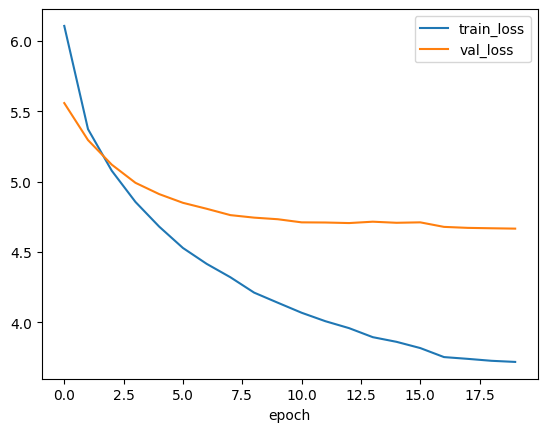

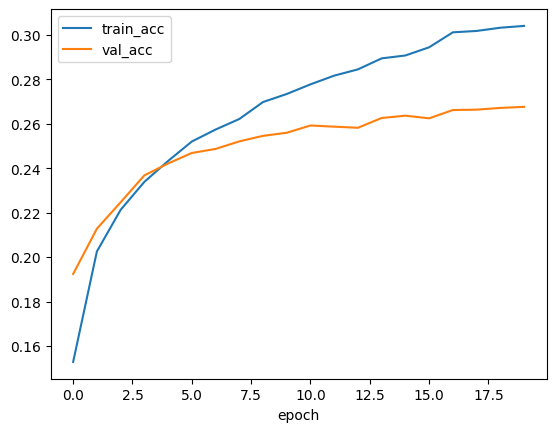

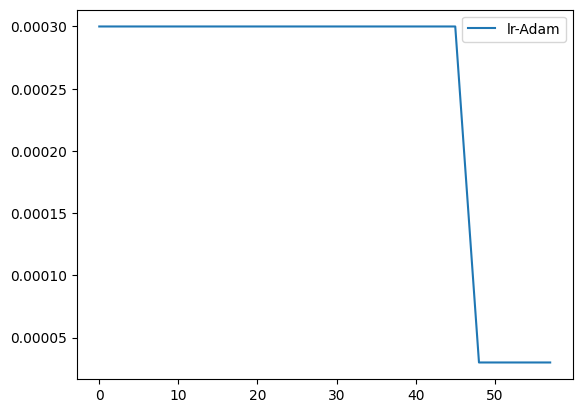

In [16]:
log = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
df = log.set_index('epoch')
df['val_loss'] = df.val_loss.shift(1)
df['val_acc'] = df.val_acc.shift(1)
df = df[df['train_loss'].notnull() | df['val_loss'].notnull()]
df[['train_loss', 'val_loss']].plot()
plt.show()
df[['train_acc', 'val_acc']].plot()
plt.show()
log[log['lr-Adam'].notnull()][['lr-Adam']].plot()
plt.show()

In [17]:
# model = Transformer.load_from_checkpoint('../models/textgen/epoch=18-step=9728.ckpt')

In [18]:
@torch.no_grad()
def sample(
        model: nn.Module,
        x: torch.Tensor,
        output_length: int,
        block_size: Optional[int],
        eos_class: Optional[int] = None,
        exclude_classes: Optional[List[int]] = None,
        temperature: float = 1,
        top_k: Optional[float] = None,
        top_p: Optional[float] = None,
        generator: Optional[torch.Generator] = None
):
    model.eval()
    seq = x

    for _ in range(output_length):
        inputs = seq[-block_size:].unsqueeze(0)
        logits = model.forward(inputs).squeeze(0)[-1]
        if exclude_classes:
            logits[exclude_classes] = float('-inf')
        logits = logits / temperature
        probas = logits.softmax(dim=-1)

        if top_k:
            probas, indices = probas.topk(top_k)
        else:
            indices = torch.arange(probas.size(-1))

        if top_p:
            sorted_probas, sorted_indices = probas.sort()  # ascending sort simplifies the following
            cumprobas = sorted_probas.cumsum(-1)
            nucleus_size = cumprobas.size(-1) - torch.sum(cumprobas <= (1 - top_p))
            nucleus_indices = sorted_indices[-nucleus_size:]
            probas = sorted_probas[-nucleus_size:]
            indices = indices[nucleus_indices]

        index = probas.multinomial(1, generator=generator)
        if index == eos_class:
            break
        seq = torch.cat([seq, indices[index]])

    return seq[x.size(-1):]

In [19]:
@torch.no_grad()
def beam_search(
        model: nn.Module,
        x: torch.Tensor,
        beam_width: int,
        output_length: int,
        block_size: Optional[int],
        eos_class: Optional[int] = None,
        exclude_classes: Optional[List[int]] = None,
        length_penalty: float = 0
):
    Node = collections.namedtuple('Node', ['path', 'proba', 'score'])
    model.eval()

    empty = torch.tensor([], dtype=torch.int64, device=model.device)
    root = Node(empty, 0.0, 0.0)
    nodes = branches = [root]
    leaves = []

    for level in range(output_length):
        candidates = []
        score_divisor = (level + 1) ** length_penalty

        # early stopping if we won't find a branch better than the current best leaf
        best_score = max(leaf.score for leaf in leaves) if leaves else float('-inf')
        early_stopping_divisor = score_divisor if length_penalty <= 0 else output_length ** length_penalty
        branches = [branch for branch in branches if branch.proba / early_stopping_divisor >= best_score]

        for branch in branches:
            _x, _path = x, branch.path
            if block_size:
                _path = branch.path[-block_size:]
                _x = x[max(x.size(0) + _path.size(0) - block_size, 0):]
            inputs = torch.cat([_x, _path]).unsqueeze(0)

            logits = model(inputs).squeeze(0)[-1]
            if exclude_classes:
                logits[exclude_classes] = float('-inf')
            probas = logits.log_softmax(0)
            probas, indices = probas.topk(beam_width)
            probas += branch.proba
            scores = probas / score_divisor
            cand = [Node(torch.cat([branch.path, indices[i:i+1]]), proba, score)
                    for i, (proba, score) in enumerate(zip(probas, scores))]
            candidates.extend(cand)

        candidates += leaves
        candidates = sorted(candidates, key=lambda node: node.score, reverse=True)
        nodes = candidates[:beam_width]
        leaves = [node for node in nodes if node.path[-1] == eos_class]
        branches = set(nodes) - set(leaves)
        if not branches:
            break

    node = max(nodes, key=lambda node: (node.path[-1] == eos_class, node.score))
    output = node.path
    if output[-1] == eos_class:
        output = output[:-1]
    return output

In [20]:
prompt = 'marry had a little lamb'
indices = torch.tensor(vocab.lookup_indices(tokenizer(prompt)), device=model.device)
exclude = vocab.lookup_indices(['<pad>', '<unk>'])
indices = sample(model, indices, 100, block_size=seq_len, exclude_classes=exclude, temperature=1, top_k=None, top_p=None)
tokens = vocab.lookup_tokens(indices.tolist())
prompt + ' ' + ' '.join(tokens)

'marry had a little lamb dispute from herself . the baby arose khamba to none separated by kongyamba . at the end of the road . meanwhile , he sang in 1964 and he sang at home at the high category . his home named with his friend josephine , he made him a sword when he was modest . first he composed a pub . his first arose was doing so , he batted at the end of his position when he was sacked at the comedy and around the world . he got at the singing and earned many performances , including the'

In [21]:
prompt = 'marry had a little lamb'
indices = torch.tensor(vocab.lookup_indices(tokenizer(prompt)), device=model.device)
exclude = vocab.lookup_indices(['<pad>', '<unk>'])
indices = beam_search(model, indices, 10, 100, block_size=seq_len, exclude_classes=exclude)
tokens = vocab.lookup_tokens(indices.tolist())
prompt + ' ' + ' '.join(tokens)

'marry had a little lamb . he was born in new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city , new york city'